In [46]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D 
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.engine.topology import Layer,InputSpec
from keras.layers import Input
from keras.layers import ConvLSTM2D
from keras.models import Model
from keras.layers.wrappers import Bidirectional, TimeDistributed

K.set_image_dim_ordering("th")

class CylindricalPadLSTMCNN(Layer):

    def __init__(self, m=0,n=1, **kwargs):
        super(CylindricalPadLSTMCNN, self).__init__(**kwargs)
        self.n = n
        self.m = m
        assert n > 0, 'n must be positive'
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(CylindricalPadLSTMCNN, self).build(input_shape)  
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0],
                input_shape[1],
                    input_shape[2],
                    input_shape[3] + 2*self.m,
                    input_shape[4] + 2*self.n)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0],
                input_shape[1],
                    input_shape[2],
                    input_shape[3] + 2*self.m,
                    input_shape[4] + 2*self.n)
    
    def call(self,testElement, mask=None):
        firstColumns=testElement[:,:,:,:,0:self.n]
        lastColumns=testElement[:,:,:,:,testElement.shape[4]-self.n:testElement.shape[4]]
        result=tf.concat([testElement,firstColumns], axis=4)
        result=tf.concat([lastColumns,result], axis=4)
        if self.m != 0 :
            #x = tf.placeholder(result.dtype, shape=[result.shape[0],result.shape[1],self.m,result.shape[3]])
            #y = tf.zeros_like(x,dtype=result.dtype)
            
            firstRows=result[:,:,:,0:self.m,:]
            
            y = tf.fill(tf.shape(firstRows), 0.)
            
            #y=tf.fill([result.shape[0],result.shape[1],self.m,result.shape[3]],0.)
            
            #y = tf.constant(0., shape=[result.shape[0],result.shape[1],self.m,result.shape[3]],dtype=result.dtype)
            result=tf.concat([y,result], axis=3)
            result=tf.concat([result,y], axis=3)
        
        return result

    def get_config(self):
        config = {'n': self.n,
        'm': self.m}
        base_config = super(CylindricalPadLSTMCNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

print("CylindricalPad class layer defined")


class CNNLSTMROLL:
    @staticmethod
    def build(timeSteps,rows, cols,classes):
        
        inputNet = Input(shape=(timeSteps,1,rows, cols)) #batch_shape=(20, 7, 5) 
        cyPad1=CylindricalPadLSTMCNN(m=0,n=3)(inputNet)
        convlstm2d=Bidirectional(ConvLSTM2D(20, kernel_size=(2,7), padding="valid", dropout=0.2, recurrent_dropout=0.1,return_sequences=True))(cyPad1)
        convlstm2d=CylindricalPadLSTMCNN(m=0,n=1)(convlstm2d)
        convlstm2d=ConvLSTM2D(10, kernel_size=(2,3), padding="valid", dropout=0.2, recurrent_dropout=0.1)(convlstm2d)
        
        flat=Flatten()(convlstm2d)
        denselayers=Dense(400)(flat)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.5)(denselayers)
        denselayers=Dense(150)(denselayers)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.8)(denselayers)
        # a softmax classifier
        classificationLayer=Dense(classes)(denselayers)
        classificationLayer=Activation("softmax")(classificationLayer)
        
        #classificationLayer=Activation("softmax")(classificationLayer)
        
        model=Model(inputNet,classificationLayer)
        return model

CylindricalPad class layer defined


In [47]:
# load data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split

def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

# load all data
dfin = pd.read_csv('windows-size72-step12.csv',header=None)  #inputs 72 lines per sample
dfout = pd.read_csv('out-class-size72-step12.csv',header=None)  #output classes 

total_inputs,total_output = dfin.as_matrix().astype(np.float32),dfout.as_matrix().astype(np.int32)

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
total_inputs = scaler.fit_transform(total_inputs)

# every 72 lines is one input sample
total_inputs = np.reshape(total_inputs, (-1,72,8))
total_inputs = np.reshape(total_inputs, (-1,6,12,8))

print("############# total shapes #############")
print(total_inputs.shape)
print(total_output.size)

train_inputs, test_inputs, train_output, test_output = non_shuffling_train_test_split(total_inputs, total_output, test_size=0.2)
print("############# train shapes #############")
print(train_inputs.shape)
print(train_output.shape)

print("############# test shapes #############")
print(test_inputs.shape)
print(test_output.shape)



############# total shapes #############
(2876, 6, 12, 8)
2876
############# train shapes #############
(2301, 6, 12, 8)
(2301, 1)
############# test shapes #############
(575, 6, 12, 8)
(575, 1)


/home/rjpg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [48]:

IMG_ROWS, IMG_COLS = 72, 8 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes

X_train = train_inputs[:,:, np.newaxis, :, :]
y_train = np_utils.to_categorical(train_output, NB_CLASSES)
X_test = test_inputs[:,:, np.newaxis, :, :]
y_test = np_utils.to_categorical(test_output, NB_CLASSES)
print(y_test.shape)

OPTIMIZER = Adam()

model = CNNLSTMROLL.build(timeSteps=6,rows=12, cols=8,classes=5)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

model.summary()


(575, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 6, 1, 12, 8)       0         
_________________________________________________________________
cylindrical_pad_lstmcnn_21 ( (None, 6, 1, 12, 14)      0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 6, 20, 11, 16)     47200     
_________________________________________________________________
cylindrical_pad_lstmcnn_22 ( (None, 6, 20, 11, 18)     0         
_________________________________________________________________
conv_lst_m2d_22 (ConvLSTM2D) (None, 10, 10, 16)        7240      
_________________________________________________________________
flatten_11 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 400)               640400    
_

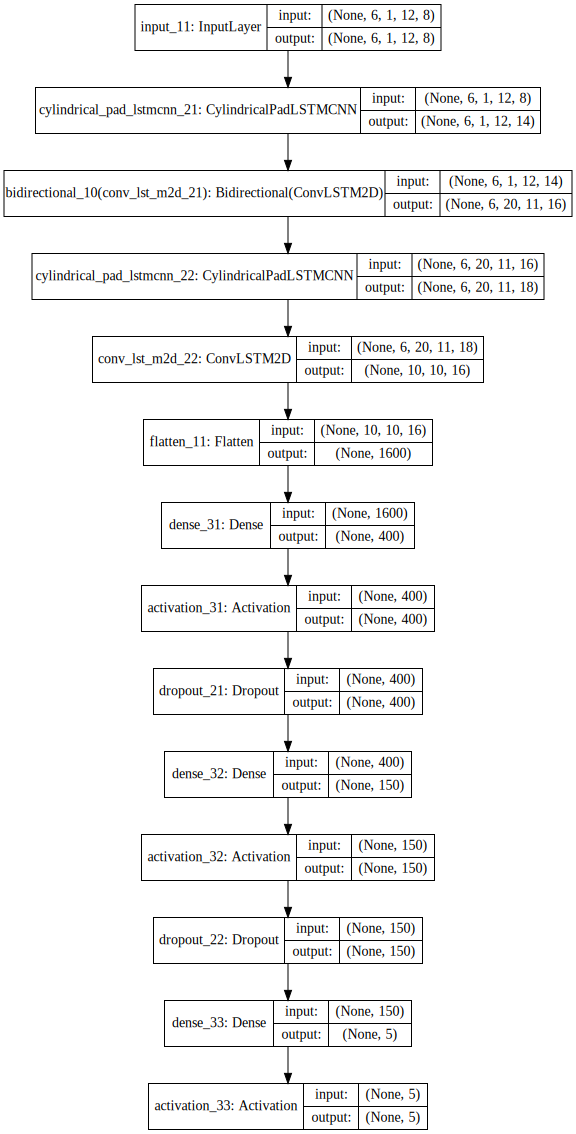

In [49]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

In [50]:
NB_EPOCH = 100
BATCH_SIZE = 64
VERBOSE = 1

#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
#esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
best_checkpoint = ModelCheckpoint('CNNLSTM-ROLL-energie.h5', monitor='val_acc', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_data=(X_test,y_test),
		#validation_split=VALIDATION_SPLIT,
		callbacks=[best_checkpoint])

Train on 2301 samples, validate on 575 samples
Epoch 1/100
2301/2301 [==============================] - 6s 3ms/step - loss: 1.6082 - acc: 0.2216 - val_loss: 1.5964 - val_acc: 0.2591

Epoch 00001: val_acc improved from -inf to 0.25913, saving model to CNNLSTM-ROLL-energie.h5
Epoch 2/100
2301/2301 [==============================] - 2s 1ms/step - loss: 1.5510 - acc: 0.2890 - val_loss: 1.4881 - val_acc: 0.2661

Epoch 00002: val_acc improved from 0.25913 to 0.26609, saving model to CNNLSTM-ROLL-energie.h5
Epoch 3/100
2301/2301 [==============================] - 2s 1ms/step - loss: 1.4943 - acc: 0.3238 - val_loss: 1.4649 - val_acc: 0.2765

Epoch 00003: val_acc improved from 0.26609 to 0.27652, saving model to CNNLSTM-ROLL-energie.h5
Epoch 4/100
2301/2301 [==============================] - 2s 1ms/step - loss: 1.4654 - acc: 0.3451 - val_loss: 1.4630 - val_acc: 0.3009

Epoch 00004: val_acc improved from 0.27652 to 0.30087, saving model to CNNLSTM-ROLL-energie.h5
Epoch 5/100
2301/2301 [=========

2301/2301 [==============================] - 3s 1ms/step - loss: 1.3236 - acc: 0.4120 - val_loss: 1.3837 - val_acc: 0.3948

Epoch 00042: val_acc did not improve from 0.42957
Epoch 43/100
2301/2301 [==============================] - 2s 1ms/step - loss: 1.3299 - acc: 0.4133 - val_loss: 1.3816 - val_acc: 0.3791

Epoch 00043: val_acc did not improve from 0.42957
Epoch 44/100
2301/2301 [==============================] - 2s 1ms/step - loss: 1.3205 - acc: 0.4185 - val_loss: 1.3501 - val_acc: 0.3861

Epoch 00044: val_acc did not improve from 0.42957
Epoch 45/100
2301/2301 [==============================] - 2s 1ms/step - loss: 1.3207 - acc: 0.4181 - val_loss: 1.3576 - val_acc: 0.4070

Epoch 00045: val_acc did not improve from 0.42957
Epoch 46/100
2301/2301 [==============================] - 3s 1ms/step - loss: 1.3302 - acc: 0.4268 - val_loss: 1.3523 - val_acc: 0.4000

Epoch 00046: val_acc did not improve from 0.42957
Epoch 47/100
2301/2301 [==============================] - 2s 1ms/step - loss: 

2301/2301 [==============================] - 2s 1ms/step - loss: 1.2178 - acc: 0.4624 - val_loss: 1.3763 - val_acc: 0.3930

Epoch 00086: val_acc did not improve from 0.42957
Epoch 87/100
2301/2301 [==============================] - 2s 1ms/step - loss: 1.2165 - acc: 0.4781 - val_loss: 1.3854 - val_acc: 0.3878

Epoch 00087: val_acc did not improve from 0.42957
Epoch 88/100
2301/2301 [==============================] - 2s 1ms/step - loss: 1.2170 - acc: 0.4694 - val_loss: 1.4154 - val_acc: 0.3722

Epoch 00088: val_acc did not improve from 0.42957
Epoch 89/100
2301/2301 [==============================] - 2s 1ms/step - loss: 1.2010 - acc: 0.4859 - val_loss: 1.3795 - val_acc: 0.3791

Epoch 00089: val_acc did not improve from 0.42957
Epoch 90/100
2301/2301 [==============================] - 3s 1ms/step - loss: 1.2029 - acc: 0.4794 - val_loss: 1.3891 - val_acc: 0.4087

Epoch 00090: val_acc did not improve from 0.42957
Epoch 91/100
2301/2301 [==============================] - 2s 1ms/step - loss: 

In [51]:
import json,codecs
import numpy as np
def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           if  type(history.history[key][0]) == np.float64:
               new_hist[key] = list(map(float, history.history[key]))

    #print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n


saveHist('CNNLSTM-ROLL-energie.hist',history)
hist=loadHist('CNNLSTM-ROLL-energie.hist')




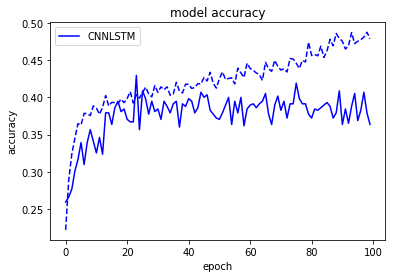

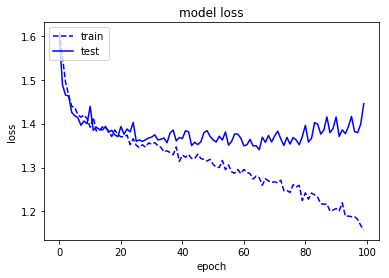

In [52]:
import matplotlib.pylab as plt

acc=np.array(hist['acc'])
#acc=acc[0:100]
#acc=np.append(acc,[0.7])
plt.plot(acc,'b--')
plt.plot(hist['val_acc'],'b',label='CNNLSTM')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
# summarize history for loss
loss=np.array(hist['loss'])
#loss=np.append(loss,[2])
plt.plot(loss,'b--',label='train')
plt.plot(hist['val_loss'],'b',label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()